In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Библиотеки

In [2]:
import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import save_image

from glob import glob
from PIL import Image
import PIL.ImageOps    
from tqdm import tqdm_notebook
import gc

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
plt.rcParams['figure.figsize'] = [15, 8]

# Загружаем датасет

In [4]:
path = "/kaggle/input/edges2portrait/edges2portrait"

In [5]:
class PortraitsDataset(Dataset):
    def __init__(self, root):
        self.root = root
        
        self.files_A = sorted(glob(os.path.join(root, "trainA") + "/*.*"))
        self.files_B = sorted(glob(os.path.join(root, "trainB") + "/*.*"))
        
        assert len(self.files_A) == len(self.files_B)
        
        self.len_ = len(self.files_A)
        
        self.transforms = v2.Compose([
            v2.ToTensor(),
            v2.Grayscale(num_output_channels=1), # картинки серые
            v2.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return self.len_

    def __getitem__(self, idx):
        image_A = PIL.ImageOps.invert(Image.open(self.files_A[idx]))
        # почему-то здесь рисунки белым по черному
        image_B = Image.open(self.files_B[idx])
        
        image_A = self.transforms(image_A)
        image_B = self.transforms(image_B)
           
        return image_A, image_B 

In [6]:
class AugmentedDataset(Dataset):
  def __init__(self, base_dataset):
    super(AugmentedDataset, self).__init__()
    self.base = base_dataset
    self.augmentations = v2.Compose([
        v2.Resize((286,286),v2.InterpolationMode.NEAREST),
        v2.RandomCrop((256,256)),
        v2.RandomHorizontalFlip(p=0.5),
    ]) 

  def __len__(self):
    return len(self.base)

  def __getitem__(self, idx):
    image_A, image_B = self.base[idx]
            
    glued_images = torch.cat((image_A, image_B), dim = 0)
    # нам нужно, чтобы все аугментации применялись одинаково
            
    glued_images = self.augmentations(glued_images)
    
    # нужно через двоеточие для сохранения размерности      
    return glued_images[0:1], glued_images[1:2]

In [7]:
dataset = PortraitsDataset(path)
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_test = num_items - num_train
dataset_train, dataset_test = random_split(dataset, [num_train, num_test])
dataset_train = AugmentedDataset(dataset_train)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
def to_image(tensor):
    return tensor.permute(1,2,0) * 0.5 + 0.5

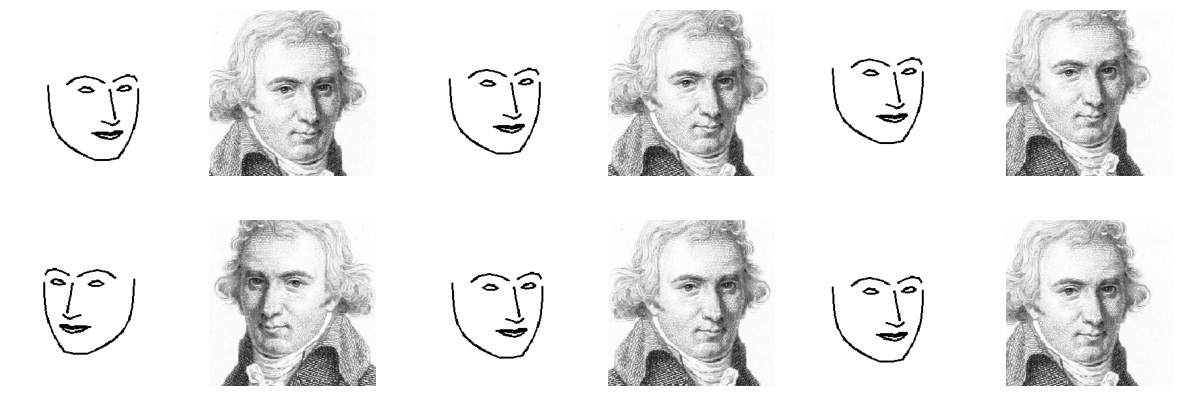

In [9]:
fig, ax = plt.subplots(2, 6, figsize=(15,5))

ax = ax.ravel()

for i in range(0, 2*6, 2):
    a,b = dataset_train[1]
    ax[i].imshow(to_image(a), cmap='gray')
    ax[i].axis('off')
    ax[i+1].imshow(to_image(b), cmap='gray')
    ax[i+1].axis('off')
fig.show()

Random jitter & mirroring

In [10]:
train_dl = DataLoader(dataset_train, batch_size=50, shuffle=True, pin_memory=True)
test_dl = DataLoader(dataset_test, batch_size=10, shuffle=False, pin_memory=True)

In [11]:
X_test, y_test = next(iter(test_dl))
X_test.shape, y_test.shape

(torch.Size([10, 1, 256, 256]), torch.Size([10, 1, 256, 256]))

# Архитектура генератора

Let Ck denote a Convolution-BatchNorm-ReLU layer with k filters. CDk denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All convolutions are 4× 4 spatial filters applied with stride 2. Convolutions in the encoder, and in the discriminator, downsample by a factor of 2, whereas in the decoder they upsample by a factor of 2.

The encoder-decoder architecture consists of:

encoder:

C64-C128-C256-C512-C512-C512-C512-C512

decoder:

CD512-CD512-CD512-C512-C256-C128-C64

After the last layer in the decoder, a convolution is applied to map to the number of output channels (3 in general, except in colorization, where it is 2), followed by a Tanh function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer in the encoder. All ReLUs in the encoder are leaky, with slope 0.2, while ReLUs in the decoder are not leaky.

The U-Net architecture is identical except with skip connections between each layer i in the encoder and layer n−i in the decoder, where n is the total number of layers. The skip connections concatenate activations from layer i to layer n − i. This changes the number of channels in the decoder:

U-Net decoder:

CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128


In [12]:
class EncoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels, apply_batchnorm = True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        )
        if apply_batchnorm:
            self.conv.append(nn.BatchNorm2d(out_channels))
        self.conv.append(nn.LeakyReLU())

    def forward(self, x):
        return self.conv(x)

In [13]:
class DecoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels, apply_dropout = False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        )
        if apply_dropout:
            self.conv.append(nn.Dropout())
        self.conv.append(nn.ReLU())

    def forward(self, x):
        return self.conv(x)

In [14]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder_blocks = nn.Sequential(
            EncoderBlock(in_channels, 64, apply_batchnorm=False), #128
            EncoderBlock(64, 128), #64
            EncoderBlock(128, 256), #32
            EncoderBlock(256, 512), #16
            EncoderBlock(512 ,512), #8
            EncoderBlock(512 ,512), #4
            EncoderBlock(512 ,512), #2
            EncoderBlock(512 ,512, apply_batchnorm=False), #1 
        )
        
        self.decoder_blocks = nn.Sequential(
            DecoderBlock(512, 512, apply_dropout = True), #2
            DecoderBlock(512+512, 512, apply_dropout = True), #4
            DecoderBlock(512+512, 512, apply_dropout = True), #8
            DecoderBlock(512+512, 512), #16
            DecoderBlock(512+512, 256), #32
            DecoderBlock(256+256, 128), #64
            DecoderBlock(128+128, 64), #128
        )
        
        self.out = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def encode(self,x):
        skip_list = []
        for block in self.encoder_blocks:
            x = block(x)
            skip_list.append(x)
        skip_list = reversed(skip_list[:-1])
        return x, skip_list
    
    def decode(self,x,skip_list):
        for block,skip in zip(self.decoder_blocks,skip_list):
            x = block(x)
            x = torch.cat([x, skip], dim=1)
        x = self.out(x)
        return x
        

    def forward(self, x):
        x, skip_list = self.encode(x)
        return self.decode(x,skip_list)

In [15]:
generator = Generator(in_channels = 1, out_channels = 1)
generator

Generator(
  (encoder_blocks): Sequential(
    (0): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (3): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

In [16]:
generator(X_test).shape, y_test.shape

(torch.Size([10, 1, 256, 256]), torch.Size([10, 1, 256, 256]))

In [17]:
def plot_comparison(X_test, y_gen, y_real):
    clear_output(wait=True)
    fig, ax = plt.subplots(3, 6, figsize=(15,8))

    ax = ax.ravel()

    for i in range(6):
        ax[i].imshow(to_image(X_test[i]), cmap='gray')
        ax[i].axis('off')
        ax[i].title.set_text("input")
        ax[i+6].imshow(to_image(y_gen[i]), cmap='gray')
        ax[i+6].axis('off')
        ax[i+6].title.set_text("gen")
        ax[i+12].imshow(to_image(y_real[i]), cmap='gray')
        ax[i+12].axis('off')
        ax[i+12].title.set_text("real")
    fig.show()

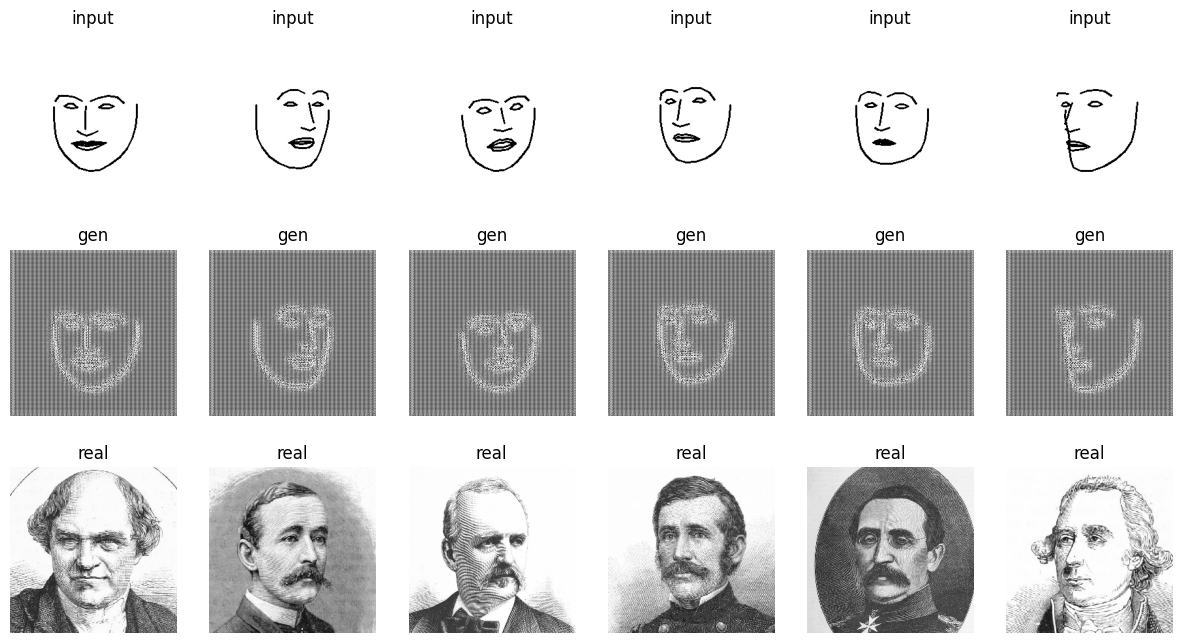

In [18]:
plot_comparison(X_test, generator(X_test).detach(), y_test)

In [19]:
generator.train();

Генератор по задумке авторов должен быть всегда в трейне, чтобы всегда работали дропауты и пересчитывались батчнормы

# Архитектура дискриминатора

The 70 × 70 discriminator architecture is:

C64-C128-C256-C512

After the last layer, a convolution is applied to map to a 1-dimensional output, followed by a Sigmoid function. As an exception to the above notation, BatchNorm is not applied to the first C64 layer. All ReLUs are leaky, with slope 0.2.

В статье не очень понятно, какие где нужно использовать страйды, но в конечном счёте должно получиться "Марковская сеть" размера 30 на 30

In [20]:
class Discriminator(nn.Module):

    def __init__(self, channels_input, channels_output):
        super().__init__()
        self.disc = nn.Sequential(
            EncoderBlock(channels_input+channels_output, 64, apply_batchnorm=False), #128
            EncoderBlock(64, 128), #64
            EncoderBlock(128, 256), #32
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1), #31
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1), #30
            # без активации, будем использовать логиты
        )
        
    def forward(self, x):
        return self.disc(x)

In [21]:
discriminator = Discriminator(1, 1)
discriminator

Discriminator(
  (disc): Sequential(
    (0): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (2): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6):

In [22]:
discriminator(torch.cat([X_test, y_test], dim=1)).shape

torch.Size([10, 1, 30, 30])

In [23]:
discriminator.train();

Дискриминатор тоже всегда трейн, потому что на инференсе он нам не нужен

# Определим функции потерь и оптимизаторы

In [24]:
L1_loss = nn.L1Loss()
BCE_loss = nn.BCEWithLogitsLoss()

In [25]:
def generator_loss(y_gen, disc_y_gen, y_real, Lambda = 100):
    return BCE_loss(disc_y_gen, torch.ones_like(disc_y_gen)) + Lambda * L1_loss(y_gen,y_real)

In addition, we divide the objective by 2 while optimizing D, which slows down the rate at which D learns relative to G.

Делим на 2

In [26]:
def discriminator_loss(disc_real, disc_y_gen):
    return (BCE_loss(disc_real, torch.ones_like(disc_real)) + BCE_loss(disc_y_gen, torch.zeros_like(disc_y_gen))) * 0.5

We use minibatch SGD andapply the Adam solver [32], with a learning rate of 0.0002, and momentum parameters β1 = 0.5, β2 = 0.999.

In [27]:
generator_opt = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Обучим GAN

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [29]:
generator = generator.to(device)
discriminator = discriminator.to(device)

In [30]:
def save_model(epoch, model, optimizer, name):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f"{name}_{epoch}.pt")

In [31]:
def train(generator, discriminator, generator_opt, discriminator_opt,
          generator_loss, discriminator_loss, epochs, data_tr, data_test):
    X_test, Y_test = next(iter(data_test))

    for epoch in range(1, epochs + 1):
        print('* Epoch %d/%d' % (epoch, epochs))        
        
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            
            # train discriminator
            discriminator_opt.zero_grad()
            
            disc_real = discriminator(torch.cat([X_batch, Y_batch], dim=1))
            Y_gen = generator(X_batch)
            disc_Y_gen = discriminator(torch.cat([X_batch, Y_gen], dim=1))
            
            loss = discriminator_loss(disc_real, disc_Y_gen) # forward-pass
            loss.backward()  # backward-pass
            discriminator_opt.step()  # update weights
            
            # train generator
            generator_opt.zero_grad()
            
            Y_gen = generator(X_batch)
            disc_Y_gen = discriminator(torch.cat([X_batch, Y_gen], dim=1))
            
            loss = generator_loss(Y_gen, disc_Y_gen, Y_batch)
            loss.backward()  
            generator_opt.step()
            
        Y_gen_test = generator(X_test.to(device)).detach().cpu()
         
        # save results
        if epoch % 25 == 0:
            save_model(epoch, generator, generator_opt, "generator")
            save_model(epoch, discriminator, discriminator_opt, "discriminator")
            save_image(torch.cat((X_test[0], Y_gen_test[0],
                                  Y_test[0]),dim = 2), f"{epoch}.jpg")
        
        # plot_comparison(X_test, Y_gen_test, Y_test) почему-то моя функция ничего не рисовала
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(to_image(X_test[k]), cmap='gray')
            plt.title('Input')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(to_image(Y_gen_test[k]), cmap='gray')
            plt.title('Gen')
            plt.axis('off')
            
            plt.subplot(3, 6, k+13)
            plt.imshow(to_image(Y_test[k]), cmap='gray')
            plt.title('Real')
            plt.axis('off')
        plt.show()
        
        torch.cuda.empty_cache()
        gc.collect()

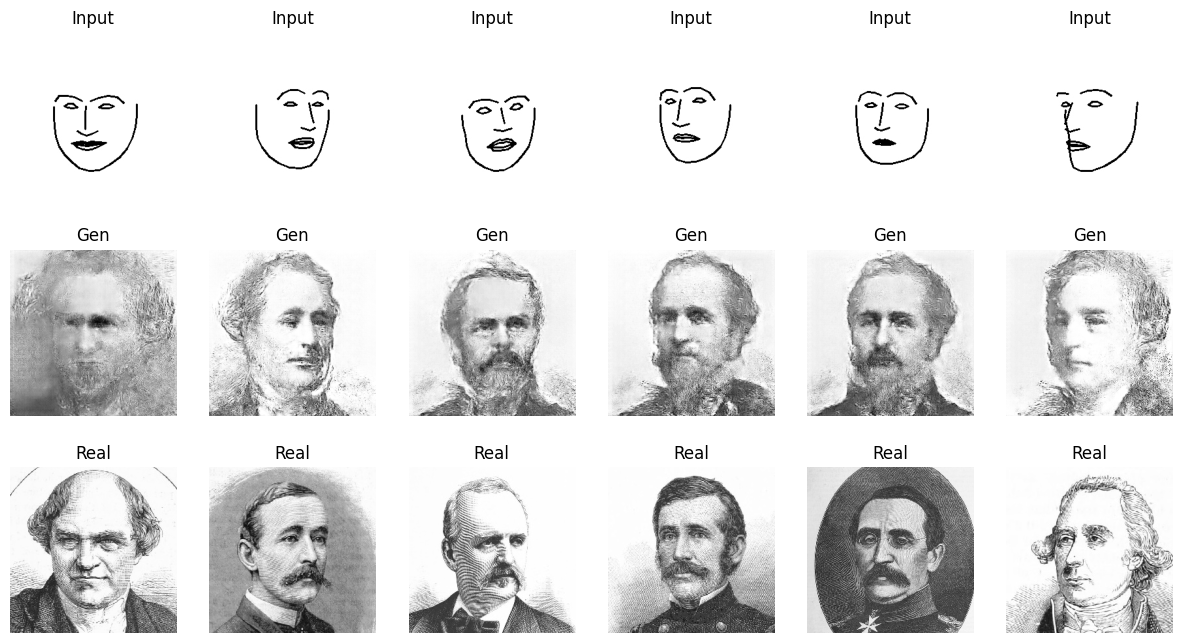

In [32]:
train(generator, discriminator, generator_opt, discriminator_opt,
      generator_loss, discriminator_loss, 150, train_dl, test_dl)

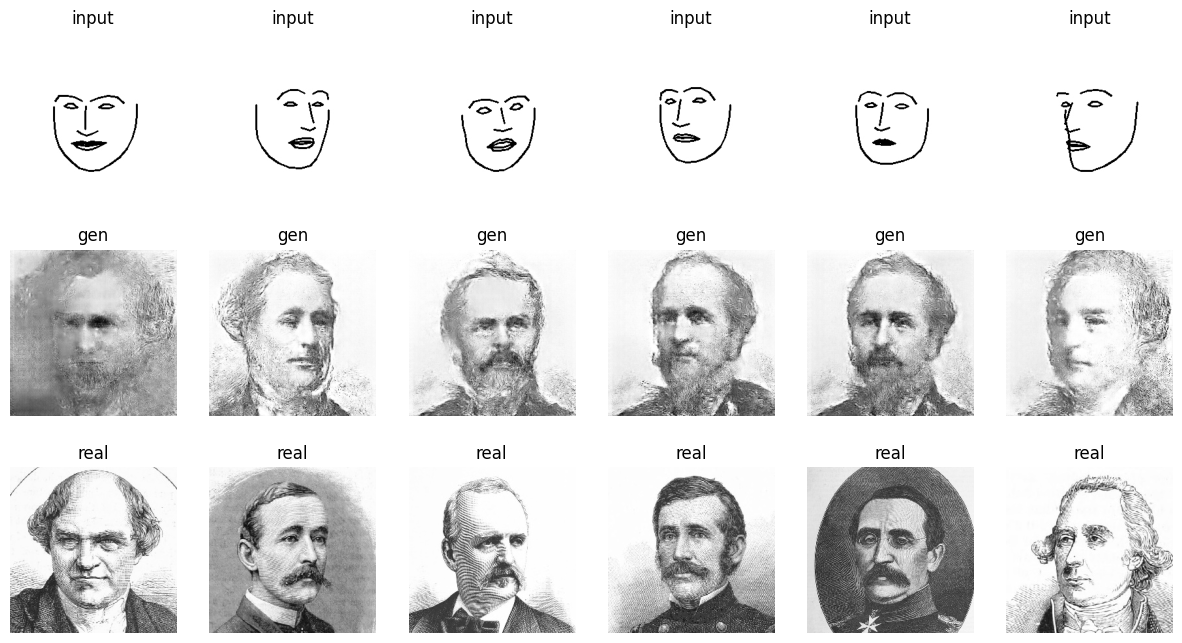

In [33]:
X_test, y_test = next(iter(test_dl))
plot_comparison(X_test, generator(X_test.to(device)).detach().cpu(), y_test)

# Метрика FID

In [34]:
gen_batches = []
for X_batch, _ in test_dl:    
    X_batch = X_batch.to(device)
    with torch.set_grad_enabled(False):
        gen_batches.append(generator(X_batch).detach().cpu()* 0.5 + 0.5)

fake_images = torch.cat(gen_batches, dim=0)

In [35]:
real_batches = []
for _, Y_batch in test_dl:    
    real_batches.append(Y_batch * 0.5 + 0.5)

real_images = torch.cat(real_batches, dim=0)

In [36]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.0 MB/s eta 0:00:00


In [37]:
from torcheval.metrics import FrechetInceptionDistance

In [38]:
FID = FrechetInceptionDistance(device = device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 54.8MB/s]


In [39]:
fake_images.shape, real_images.shape

(torch.Size([634, 1, 256, 256]), torch.Size([634, 1, 256, 256]))

In [40]:
#Принимает только 3 канала
FID.update(fake_images.expand(-1,3,-1,-1), False)
FID.update(real_images.expand(-1,3,-1,-1), True)

In [41]:
fid = FID.compute().detach().cpu()
fid

tensor(126.4458)